*This python notebook is part of a student research project for KTH - Programming for Data Science course.*

### **Title**: Estimating the true probability distribution of categorical data using Variational Autoencoders (VAEs) 

**Group Number**:  5 

**Team members**: Ceren Dikmen, Jakob Heyder, Lutfi Altin, Muhammad Fasih Ullah

**Background**


> Monte carlo simulations are widely used e.g. in financial simulations. However, it remains hard to estimate the underlying data distributions for dependent random variables. Generative Networks have been shown much success in recent years to estimate the true probability distribution and generate new samples. In this study we want to propose Variational Autoencoders to solve the problem of defining the true probability distribution from historical data, that can be sampled from in Monte Carlo Simulations.




**Research question**: 
1.  *Main*: Can VAEs estimate the complex underlying probability distribution for categorical data?
2.  *Extra*: Could the generated samples be evaluated using Monte Carlo simulations?


**Method**: 
> In this project, we will implement a state of the art VAE that will estimate the true probability distribution of categorical data. After training the Encoder and Decoder Network using the reconstruction loss and KL-Divergence, the VAE-model will be evaluated by sampling generated instances and using them in a simple Monte Carlo simulation. The result of the simulation will be compared to the outcome of the simulation with the true data. The true data will be generated from a complex distribution in the first place, this makes it possible to measure the true similarity of the estimated distribution, instead of assuming a multivariate Gaussian. We will use python with frameworks as Pandas for mixed data representation, as well as Keras and Tensorflow for the implementation of the data generation, VAE and Monte Carlo simulation.


**Results**: The project will implement,

*   Generation of synthetic categorical data
*   A Variational Autoencoder for categorical data
*   A simple Monte Carlo experiment

> The results of the project result will be the similarity measure of the outcome from the Monte Carlo Simulation with the generated data and the true data. Additionally, the result will be the training-performance of the VAE on a data-similarity measure for the true data, also called reconstruction loss.



In [0]:
!pip install tensorboardcolab

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboardcolab import *


# options defined
%matplotlib inline
np.random.seed(1)        # for consistency between runs
slim = tf.contrib.slim   # light-weight library for defining, training and evaluating complex models
tbc = TensorBoardColab() # library for plotting the network


Wait for 8 seconds...
TensorBoard link:
http://00c03458.ngrok.io


In [0]:
############### 1.) DEFINE HELPER FUNCTIONS ###############

def one_hot(samples, shape):
    encoded = []
    
    for s in samples:
        row = np.zeros(np.sum(shape))
        for i,cat in enumerate(s):
            row[np.sum(np.array(shape)[:i]) + cat] = 1
        encoded.append(row)

    return np.array(encoded)

# returns the encoded x with a category for each feature (from one-hot encoded probabilities for each category)
def one_hot_reverse(encoded, shape):
    samples = []
    
    # take the maximum probability of all categories from a feature 
    for r in encoded:
        s = []
        for i in range(len(shape)):
            start = np.sum(np.array(shape)[:i])
            end = start + shape[i]
            cat = np.argmax( r[start:end] ) 
            s.append(cat)
        samples.append(s)
        
    return samples

def compute_mmd(x, y):   # [batch_size, z_dim] [batch_size, z_dim]
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random_uniform(shape,minval=0,maxval=1)
  return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
  """Sample from the Gumbel-Softmax distribution and optionally discretize.
  Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  y = gumbel_softmax_sample(logits, temperature)
  if hard:
    k = tf.shape(logits)[-1]
    #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
    y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
    y = tf.stop_gradient(y_hard - y) + y
  return y

# Part 1: Synthetic Categorical Data Generation from a complex distribution

For the generation of the categorical data it is important that we use a complex multimodal distribution which has dependencies between variables. Based on the data generated from that distribution we will test if the VAE can learn such complex distribution for categorical data.



In [0]:
############### 1.) DEFINE COMPLEX DISTRIBUTION ###############
# dependent R.V.s (even numbers are dependent on their identical number and only appear then. E.g. 0-0-0, 2-2-2 but never 1-2-3)
distribution_f1_f2_f3 = np.array([[
    [0.04, 0, 0, 0, 0],
    [0    , 0, 0, 0, 0],
    [0    , 0, 0, 0, 0],
    [0    , 0, 0, 0, 0]
], # 0-0-0 = 4%
[
    [0, 0   , 0, 0   , 0],
    [0, 0.05, 0, 0.22, 0],
    [0, 0   , 0, 0   , 0],
    [0, 0.14, 0, 0.20, 0]
], # 1-1-1 = 5%, 1-1-3 = 22% , 1-3-1 = 14% , 1-3-3 = 20% => total: 61%
[
    [0, 0, 0   , 0, 0],
    [0, 0, 0   , 0, 0],
    [0, 0, 0.35, 0, 0],
    [0, 0, 0   , 0, 0]
]]) # 2-2-2 = 35%

distribution_f4_f5 = np.array([
    [0.1,    0,   0,    0, 0],
    [  0, 0.05,   0, 0.05, 0],
    [  0,    0, 0.5,    0, 0],
    [  0, 0.15,   0, 0.15, 0]
])

# independent R.V.s
marginal_distributions = np.array([
    np.array([0, 0.1, 0, 0.9]), # f6
    np.full((20,), 0.05), # f7
    np.full((100,), 0.01) # f8
])

# all distributions listed
distributions = np.array([
    distribution_f1_f2_f3,
    distribution_f4_f5,
    *marginal_distributions
])
    
# GENERIC: combine to X distributions into complex multivariate distribution    
# initialize a distribution
distribution = distributions[0]
# add dimensions to create joint distribution (of previous and new)
for idx, distr in enumerate(distributions[1:]):
    prev_distr = distribution
    distribution = np.zeros(distr.shape + prev_distr.shape)
    # normalize probabilities
    for i, prob in np.ndenumerate(distr):
        distribution[i] = prob * prev_distr
    
        
# print statistics about generated distribution
print("total sum distribution:", np.sum(distribution))
print("Number of features:", len(distribution.shape))
print("Number of categories per feature: ", distribution.shape)
feature_labels = ["f" + str(i+1) for i in reversed(range(len(distribution.shape)))]
print("Feature labels:", feature_labels)
print("Features "+ str(len(distribution.shape)) +"..1: ", "(uniform, uniform, custom, dependent_f4, dependent_f5, dependent_f1_f2, dependent_f1_f3, dependent_f3_f2)")



total sum distribution: 1.0000000000000044
Number of features: 8
Number of categories per feature:  (100, 20, 4, 4, 5, 3, 4, 5)
Feature labels: ['f8', 'f7', 'f6', 'f5', 'f4', 'f3', 'f2', 'f1']
Features 8..1:  (uniform, uniform, custom, dependent_f4, dependent_f5, dependent_f1_f2, dependent_f1_f3, dependent_f3_f2)


In [0]:
############### 2.) DRAW SAMPLES ###############
sample_size = 50000

def draw_samples(sample_size):
    positions = []
    probabilities = []
    for index,x in np.ndenumerate(distribution):
        positions.append(index)
        probabilities.append(x)

    true_samples = np.random.choice(len(positions), sample_size, p=probabilities)

    true_samples = [positions[i] for i in true_samples]
    return true_samples

true_samples = draw_samples(sample_size)

print("Total sample size:", sample_size)
print("First 10 samples drawn:")
true_samples[:10]

Total sample size: 50000
First 10 samples drawn:


[(41, 14, 1, 2, 2, 1, 3, 3),
 (72, 0, 3, 2, 2, 2, 2, 2),
 (0, 0, 3, 1, 1, 2, 2, 2),
 (30, 4, 3, 2, 2, 2, 2, 2),
 (14, 13, 3, 2, 2, 1, 3, 3),
 (9, 4, 3, 2, 2, 2, 2, 2),
 (18, 12, 3, 2, 2, 1, 3, 3),
 (34, 11, 3, 0, 0, 1, 1, 3),
 (39, 13, 3, 2, 2, 1, 3, 3),
 (53, 17, 3, 2, 2, 2, 2, 2)]

# Part 2: Our VAE imlementation

Reference Papers:

* "Normal" VAE - original [paper](https://arxiv.org/abs/1312.6114)
* InfoVAE [paper](https://arxiv.org/abs/1706.02262)

------------------------------------------------------------------------------------------------------------------------------------------------------------

Loss functions: 
1. NLL: Negative Log Likelihood  [Why NLL](https://stats.stackexchange.com/questions/251496/why-sum-of-squared-errors-for-logistic-regression-not-used-and-instead-maximum-l) 
2. MSE:  Sum of squared errors 
3. ELBO:  Evidence Lower Bound 
4. MMD: Maximum Mean Distance
 
=> We compute the TOTAL_LOSS in our implementation based on InfoVAEs MMD-VAE: Combination of Reconstruction loss (NLL)  + Divergence Metrics (ELBO & MMD) 

beta =Weight parameter for divergence loss (higher beta -> more importance to fit latent-distribution, less importance to reconstruction loss)


------------------------------------------------------------------------------------------------------------------------------------------------------------

Notes: 

Categorical Data is one-hot encoded before computation (e.g. to compute reconstruction loss).

Possible extension with Gumbel-Softmax trick for categorical reparameterization [paper](https://arxiv.org/abs/1611.01144) instead of one-hot encoded.

------------------------------------------------------------------------------------------------------------------------------------------------------------

Steps:

1.   Define Encoder Network (Inference Network)
2.   Define Decoder Network (Generator Network)
3.   Define latent-variable sampler
4.   Build Model  & Specificy Parameters
5.   Define Loss-function -> NLL/MSE (Reconstruction loss) + ELBO/MMD
6.   Define evaluation functions for a trained model (MC-Score Distance and MMD-Distance)
7.   **Train the networks** using Backpropagation and **save model-scores**
8.   Generate baseline-comparison scores
9.   Plot Additional Summary of graphs to tensorflow board (e.g. model-scores over betas)



In [0]:
############### 1.) DEFINE ENCODER NETWORK ###############

def gen_encoder(x, z_dim):
    encoder = slim.stack(x, slim.fully_connected, [128, 64], scope='encoder') # hidden layers: 128, 64, fully_connected

    mean = slim.stack(encoder, slim.fully_connected, [z_dim], activation_fn=tf.identity, scope='mean')
    with tf.variable_scope('std_deviation'):
        stddev = slim.stack(encoder, slim.fully_connected, [z_dim], activation_fn=tf.sigmoid)
        stddev = tf.maximum(stddev, 0.001)

    with tf.variable_scope('input_shape'):
        input_shape = tf.shape(x)
        
    with tf.variable_scope('e'):
        e = tf.random_normal(tf.stack([input_shape[0], z_dim])) # reparametrization trick e~Normal distribution
        
    with tf.variable_scope('latent'):
        z = mean + tf.multiply(stddev, e)
    
    return mean, stddev, z

In [0]:
############### 2.) DEFINE DECODER NETWORK ###############

def gen_decoder(z, input_dim, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
            
        decoder = slim.stack(z, slim.fully_connected, [64, 128])
        xhat = slim.stack(decoder, slim.fully_connected, [input_dim], activation_fn=tf.sigmoid, scope='x_hat')
    
    return xhat

In [0]:
############### 3.) Define latent-variable sampler ###############

def generate_sampler(z_dim, input_dim):
    with tf.variable_scope('sampler'):
        z = tf.random_normal(tf.stack([1, z_dim]))
    return gen_decoder(z, input_dim, True)

In [0]:
############### 4.) BUILD MODEL ###############

# clear graphs
tf.reset_default_graph() 

# 4.1) parameters 
arg_z_dim = 10
arg_elbo = True # Use ELBO instead of MMD
arg_beta = tf.placeholder(tf.float32, [], name='Beta') # weight of divergence compared to reconstruction
betavals = [20,20,20,20,20]
number_runs = 100000
results = np.zeros((len(betavals),4)) # mean_distance, std_distance, invalid_instances, mmd_loss for each beta val


# params inferred from data
input_dim = int(np.sum(distribution.shape))
batch_size = 500
encoded_samples = one_hot(true_samples, distribution.shape)


# 4.2) build model
with tf.variable_scope('input'):
    x = tf.placeholder(tf.float32, [None, input_dim]) # input layer: shape: batchsize, dimensions(sum of categories for each feature)
train_mean, train_stddev, z = gen_encoder(x, arg_z_dim)
xhat = gen_decoder(z, input_dim)

# 4.3) build test network
sampler = generate_sampler(10, input_dim)

In [0]:
############### 5.) DEFINE LOSS ###############

with tf.variable_scope('loss'):

    # 1.) Reconstruction loss, either NLL or MSE 
    with tf.variable_scope('reconstruction'):
        
        # factorized Gaussian with mean and variance => 'negative likelihood is thus proportional to the squared distance'
        ###  Negative log likelihood per dimension
        ###  nll_per_sample = -tf.reduce_sum(tf.log(xhat) * x + tf.log(1 - xhat) * (1 - x), axis = (1,2,3)) # TODO: axis removed correct? (sum over all )
        ###  loss_rec = tf.reduce_mean(nll_per_sample)
        
        # Mean squared error    
        loss_rec = tf.reduce_mean(tf.square(xhat-x))

    # 2.) Divergence metric 
    if (not arg_elbo):
        with tf.variable_scope('mmd'):
            # Compare the generated z with true samples from a standard Gaussian, and compute their MMD distance
            true_latent_samples = tf.random_normal(tf.stack([batch_size, arg_z_dim]))
            loss_div = compute_mmd(true_latent_samples, z)
    else:
        with tf.variable_scope('elbo'):
            # KL-Divergence for maximizing expected lower bound (ELBO) => stronger constraint on the distributions
            elbo_coeff = 0.001
            loss_div = elbo_coeff * tf.reduce_mean(-tf.log(train_stddev) + 0.5 * tf.square(train_stddev) + 0.5 * tf.square(train_mean) - 0.5)

    # 3.) Combine total loss    
    loss_all = loss_rec + arg_beta * loss_div


In [0]:
############### 6.) Define model evaluation (MC-Score Distance and MMD-Distance) ###############

def baselines():
    mean_distance = np.zeros(len(betavals))
    std_distance = np.zeros(len(betavals))
    mmd_loss = np.zeros(len(betavals))

    for idx, beta in enumerate(betavals):
        mean, std, mmd = baseline()
        mean_distance[idx] = mean
        std_distance[idx] = std
        mmd_loss[idx] = mmd

    return mean_distance, std_distance, mmd_loss

# Evaluate baseline
def baseline():
    test_samples = draw_samples(sample_size)
    # Monte Carlo Simulation evaluation
    mean, std = evaluate(test_samples)
    true_mean, true_std = evaluate(true_samples)
    
    mean_distance = abs(mean - true_mean)
    std_distance = abs(std - true_std)
    
    # Distribution evaluation (using MMD distance from generated samples to true (synthetic generated) samples)
    mmd_loss = 0
    mmd_batches = 10
    for s in np.split(np.arange(len(true_samples)), mmd_batches):
        mmd_loss += compute_mmd(np.array(true_samples, dtype='float32')[s], np.array(test_samples, dtype='float32')[s]).eval()
    mmd_loss /= mmd_batches
    return mean_distance, std_distance, mmd_loss
    
# Test if original conditions hold
def valid(sample):
    return (
        # first condition: even numbers are dependent on each other and only appear together e.g. 2-2-2 and 0-0-0
        (
         (sample[7] % 2 == 0 and (sample[7] == sample[6]) and (sample[6] == sample[5])) or
         (sample[7] % 2 == 1 and sample[6] % 2 == 1 and sample[5] % 2 == 1)
        )
        and
        # 2nd condition: even numbers are dependent on each other only appear together e.g. 2-2, 0-0
        (
         (sample[4] % 2 == 0 and sample[4] == sample[3]) or
         (sample[4] % 2 == 1 and sample[3] % 2 == 1)
        )

    )

# Imaginative evaluation based on dependent variables
def evaluate_sample(sample):
    # Number of categories per feature:  (100, 20, 4, 4, 5, 3, 4, 5)
    # Feature labels: ['f8', 'f7', 'f6', 'f5', 'f4', 'f3', 'f2', 'f1']
    # Features 8..1:  (uniform, uniform, custom, dependent_f4, dependent_f5, dependent_f1_f2, dependent_f1_f3, dependent_f3_f2)

    score = 0
    # dependent variable 
    if (sample[7] % 2 == 1):
        score += sample[7] + sample[6] + sample[5]
    if (sample[4] % 2 == 1):
        score += sample[4] + sample[3]    
    score += sample[2] + sample[1]/20 + sample[0]/100   

    return score

def evaluate(samples):
    scores = np.array([evaluate_sample(sample) for sample in samples])
    mean = np.sum(scores) / len(scores)
    std = np.sqrt(np.sum(np.square(scores - mean)) / len(scores))
    
    return mean, std


def test_network():
    gen_samples = [] 
    for i in range(0, sample_size):
        sample = sess.run(sampler)
        gen_samples.append(*sample)   

    decoded_samples = one_hot_reverse(gen_samples, distribution.shape)

    print(decoded_samples[:10])

    # Last batch-run reconstruction performance
    equals = batch_x == np.round(xhat_val)
    accuracy = np.size(equals[equals == True]) / (np.size(equals[equals == False]) + np.size(equals[equals == True]))

    # Constraint Validation (Dependency)
    invalid_samples = 0
    for sample in decoded_samples:
        if not valid(sample):
            invalid_samples += 1
    invalid_samples = invalid_samples / len(decoded_samples)
    
    # Monte Carlo Simulation evaluation
    mean, std = evaluate(decoded_samples)
    true_mean, true_std = evaluate(true_samples)
    
    mean_distance = abs(mean - true_mean)
    std_distance = abs(std - true_std)
    
    # Distribution evaluation (using MMD distance from generated samples to true (synthetic generated) samples)
    mmd_loss = 0
    mmd_batches = 10
    for s in np.split(np.arange(len(true_samples)), mmd_batches):
        mmd_loss += compute_mmd(np.array(true_samples, dtype='float32')[s], np.array(decoded_samples, dtype='float32')[s]).eval()
    mmd_loss /= mmd_batches
    
    
    print('Last batch-run reconstruction accuracy: ', accuracy)
    print('Percentage of instances NOT satisfying constraing: ', invalid_samples)
    print('Score of the true data instances: ', true_mean)
    print('Score of the gen. data instances: ', mean)
    print('Mean distance and STD distance: ', mean_distance, " " , std_distance)
    print('MMD-Loss: ', mmd_loss)
        
    return mean_distance, std_distance, invalid_samples, mmd_loss

    

In [0]:
############### 7.) TRAIN NETWORK ###############

# create trainer
trainer = tf.train.AdamOptimizer(1e-3).minimize(loss_all)

# 5.1) visualize loss values
tf.summary.scalar('divergence (elbo/mmd)', loss_div)
tf.summary.scalar('reconstruction (nll/mse)', loss_rec)
tf.summary.scalar('total loss', loss_all)
merged_summaries = tf.summary.merge_all()

# 5.2) train
sess = tf.InteractiveSession()

for idx, betaval in enumerate(betavals):
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(tbc.graph_path + '/' + str(time.time()) + '-beta' + str(betaval), sess.graph)

    for i in range(number_runs):
        batch_x = encoded_samples[np.random.choice(len(encoded_samples), batch_size)]
        _, summary, xhat_val, mean_val, stddev_val, z_val = sess.run([trainer, merged_summaries, xhat, train_mean, train_stddev, z], feed_dict={x: batch_x, arg_beta:betaval})
        writer.add_summary(summary, i)
        
    print('beta ' + str(betaval))
    mean_distance, std_distance, invalid_samples, mmd_loss = test_network()
    results[idx] = [mean_distance, std_distance, invalid_samples, mmd_loss]
    writer.add_summary(tf.Summary(value=[
        tf.Summary.Value(tag="mean_distance", simple_value=mean_distance), 
    ]), betaval)
    print('z-val', z_val)
    print('------')

    writer.close()   

INFO:tensorflow:Summary name divergence (elbo/mmd) is illegal; using divergence__elbo/mmd_ instead.
INFO:tensorflow:Summary name reconstruction (nll/mse) is illegal; using reconstruction__nll/mse_ instead.
INFO:tensorflow:Summary name total loss is illegal; using total_loss instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


beta 20
[[93, 11, 3, 3, 3, 2, 2, 2], [23, 4, 3, 2, 1, 1, 1, 3], [15, 19, 3, 2, 2, 1, 3, 3], [57, 2, 3, 1, 3, 2, 2, 2], [69, 9, 3, 0, 0, 1, 3, 3], [97, 4, 3, 2, 2, 1, 3, 3], [93, 2, 3, 3, 3, 1, 1, 3], [34, 2, 3, 2, 2, 0, 0, 0], [10, 19, 1, 2, 2, 2, 2, 2], [21, 19, 3, 1, 1, 2, 2, 2]]
Last batch-run reconstruction accuracy:  0.9848551724137931
Percentage of instances NOT satisfying constraing:  0.0133
Score of the true data instances:  8.9262786
Score of the gen. data instances:  8.6726208
Mean distance and STD distance:  0.25365779999999916   0.014478543586547765
MMD-Loss:  0.02695065885782242
z-val [[ 0.09437522 -0.20158547  0.44525325 ...  0.31247297 -0.65345347
  -2.0863793 ]
 [ 0.05014671  0.44789514  1.1148094  ... -0.76608264  2.2493358
  -0.2692139 ]
 [ 0.9390001   0.62965626  1.1380363  ... -0.17019635 -0.41433686
  -1.5975907 ]
 ...
 [ 2.020072   -1.3682549  -0.82378614 ... -1.4716685  -0.9001319
   0.08721384]
 [ 0.18974619 -1.0724925   0.9835143  ... -0.64413816  0.6902771
  -

In [0]:
############### 8.) Generate Baseline: Compare generated Test-set to Training-set ###############
mean_distance, std_distance, mmd_loss = baselines()
print('Mean distance and STD distance: ', mean_distance, " " , std_distance)
print('MMD-Loss: ', mmd_loss)

Mean distance and STD distance:  [0.0152612 0.0034948 0.0226462 0.0214836 0.0197024]   [0.00923043 0.00076375 0.00719459 0.02574292 0.01177363]
MMD-Loss:  [0.00037497 0.00034145 0.00030757 0.0003425  0.00035059]


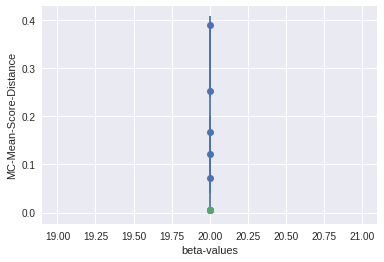

In [0]:
############### 9a.) Matplotlib pyplot graphs scores/betas ###############

x = betavals
y = results[:,0]
e = results[:,1]

plt.errorbar(x, y, e, linestyle='-', marker='o')
plt.errorbar(x, mean_distance, std_distance, linestyle='-', marker='o') # baseline
plt.xlabel('beta-values')
plt.ylabel('MC-Mean-Score-Distance')
plt.yscale('log')

plt.show()

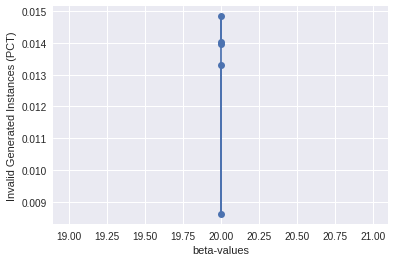

In [0]:
x = betavals
y = results[:,2]

plt.plot(x, y, linestyle='-', marker='o')
plt.xlabel('beta-values')
plt.ylabel('Invalid Generated Instances (PCT)')

plt.show()

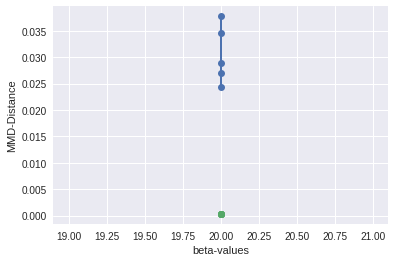

In [0]:
x = betavals
y = results[:,3]

plt.plot(x, y, linestyle='-', marker='o')
plt.plot(x, mmd_loss, linestyle='-', marker='o') # baseline
plt.xlabel('beta-values')
plt.ylabel('MMD-Distance')

plt.show()

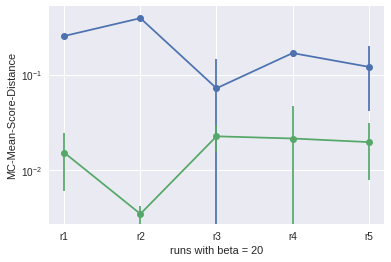

In [0]:
############### 9b.) Runs with similar betas ###############

x = ['r1', 'r2', 'r3', 'r4', 'r5']
y = results[:,0]
e = results[:,1]

plt.errorbar(x, y, e, linestyle='-', marker='o')
plt.errorbar(x, mean_distance, std_distance, linestyle='-', marker='o') # baseline
plt.xlabel('runs with beta = 20')
plt.ylabel('MC-Mean-Score-Distance')
plt.yscale('log')

plt.show()

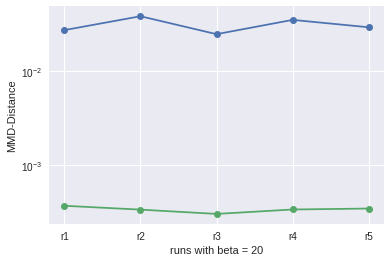

In [0]:
x = ['r1', 'r2', 'r3', 'r4', 'r5']
y = results[:,3]

plt.plot(x, y, linestyle='-', marker='o')
plt.plot(x, mmd_loss, linestyle='-', marker='o') # baseline
plt.xlabel('runs with beta = 20')
plt.ylabel('MMD-Distance')
plt.yscale('log')


plt.show()

 **TODO**: 
* Write report and sum up results for different beta values for ELBO and MMD


**Remaining Questions to investigate**:
* Are the z-latent codes disentangled? Because they do not seem to be normal Gaussian for some dimensions (should be reduced to necessary feature dimensions)
* Is z encoding the meaningful dimensions?
* MMD-VAE performance vs. ELBO + Beta parameter testing, why is MMD performing bad on categorical data?